In [1]:
import sys, os, pickle, time, re
from glob import glob
sys.path.append('../lib')
sys.path.append('../analysis')

In [2]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from array import array

import ROOT as rt
rt.TGaxis.SetMaxDigits(4)
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import ROOT.RooFit as rf
import root_numpy as rtnp

from analysis_utilities import drawOnCMSCanvas, getEff, DSetLoader
from histo_utilities import create_TH1D, create_TH2D, SetMaxToMaxHist, std_color_list
from gridVarQ2Plot import col_dic, label_dic
from progressBar import ProgressBar
from categoriesDef import categories

from lumi_utilities import getLumiByTrigger

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = 6*' ' + 'Simulation Internal'

donotdelete = []

Welcome to JupyROOT 6.12/07


In [3]:
col_dic.values()

[628, 873, 607, 393, 861, 797, 417]

In [4]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

In [5]:
df = {}
# fn = '/Low_skip13_bare.root'
fn = '/Low_bare.root'
dsMu = DSetLoader('B0_MuNuDmst_PUc0')
dfMu = pd.DataFrame(rtnp.root2array(dsMu.skimmed_dir+fn))

dsTau = DSetLoader('B0_TauNuDmst_PUc0')
dfTau = pd.DataFrame(rtnp.root2array(dsTau.skimmed_dir+fn))

In [6]:
# dfData = pd.DataFrame(rtnp.root2array('../data/cmsRD/skimmed/B2DstMu_B0_201101_Low_skip13_corr.root'))

In [7]:
s = '\n'.join([k for k in dfMu.columns[1:] if 'dca' in k or 'IP_' in k])
print(s)

mu_dca_vtxDst
mu_sigdca_vtxDst
mu_dcaT_vtxDst
mu_sigdcaT_vtxDst
mu_dca_vtxDstMu
mu_sigdca_vtxDstMu
mu_dcaT_vtxDstMu
mu_sigdcaT_vtxDstMu
MC_mu_TransvIP_PV
MC_mu_TransvIP_vtxDst
MC_mu_IP_vtxDst


In [8]:
def make_comp_plot_1D(inputs, #[x, label, color=-1 (auto), ]
                      transformX = None,
                      binning=[None, None, None],
                      setLog = '',
                      axis_title = ['', ''],
                      scale_histo = 'norm',
                      widthNorm = True,
                      opt='overflow+underflow',
                      min_y = 1e-5,
                      leg_loc=[0.6, 0.7, 0.9, 0.93] # x0, y0, w, h
                     ): 
    
    if not leg_loc is None:
        leg = rt.TLegend(leg_loc[0], leg_loc[1], leg_loc[0] + leg_loc[2], leg_loc[1] + leg_loc[3])
        leg.SetBorderSize(0)
        leg.SetFillStyle(0)
        
    colors = []
    for p in inputs:
        if len(p) > 2:
            colors.append(p[2])
        else:
            colors.append(-1)
    jStd = 0
    for i,c in enumerate(colors):
        if c == -1:
            colors[i] = std_color_list[jStd]
            jStd += 1
    
    hList = []
    for i, p in enumerate(inputs):
        if transformX is None:
            x = p[0]
        else:
            x = transformX(p[0])
        label = p[1]
        h = create_TH1D(x, 
                        binning=binning if i==0 else hList[0].binning, 
                        axis_title=axis_title,
                        scale_histo=scale_histo, widthNorm=widthNorm, opt=opt,
                       )
        h.SetLineColor(colors[i])
        if not leg_loc is None:
            leg.AddEntry(h, label, 'lp')
        hList.append(h)
            
    m = SetMaxToMaxHist(hList)
    c = drawOnCMSCanvas(CMS_lumi, hList, 'same')
    leg.Draw()
    
    if 'x' in setLog: c.SetLogx()
    if 'y' in setLog: 
        hList[0].GetYaxis().SetRangeUser(min_y, hList[0].GetYaxis().GetXmax())
        c.SetLogy()
    
    c.dnd = [hList, leg]
    return c

# General plots

In [9]:
txt = rt.TLatex()
txt.SetTextSize(0.04)
txt.SetTextFont(42)

<ROOT.TLine object ("TLine") at 0xe3bebd0>

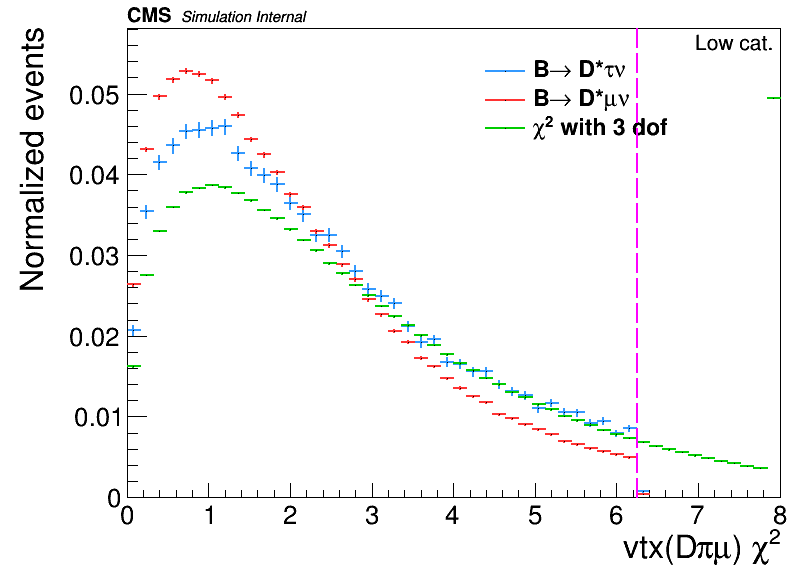

In [10]:
x= np.random.chisquare(3, int(5e6))
c = make_comp_plot_1D(
    [
        [dfTau['chi2_D0pismu'], label_dic['tau']],
        [dfMu['chi2_D0pismu'], label_dic['mu']],
        [x, '#chi^{2} with 3 dof'],
    ],
    widthNorm=False,
    binning=[50, 0, 8],
    axis_title = ['vtx(D#pi#mu) #chi^{2}', 'Normalized events'],
    leg_loc=[0.6, 0.75, 0.28, 0.15]
)

txt.SetTextAlign(33)
txt.DrawLatexNDC(0.97, 0.94, 'Low cat.')

cl.DrawLine(stats.chi2.ppf(0.9,3), 0, stats.chi2.ppf(0.9,3), c.dnd[0][0].GetMaximum())

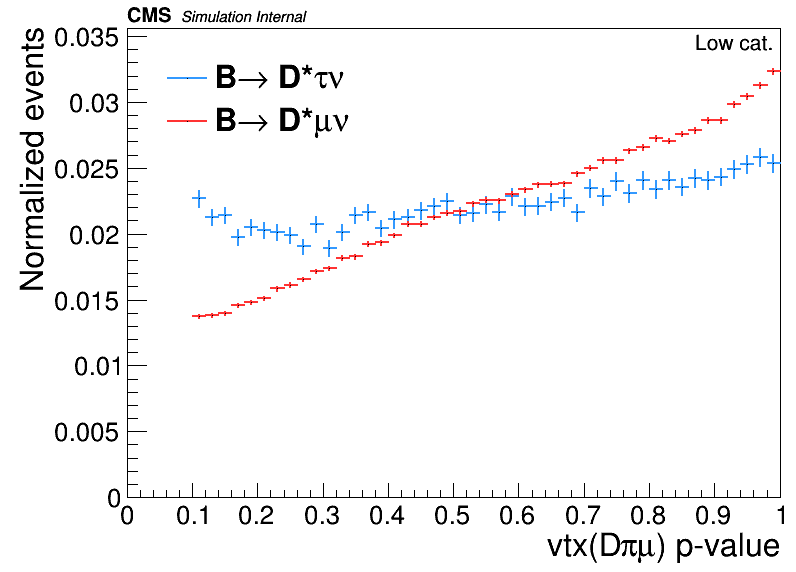

In [11]:
make_comp_plot_1D(
    [
        [dfTau['pval_D0pismu'], label_dic['tau']],
        [dfMu['pval_D0pismu'], label_dic['mu']]
    ],
    widthNorm=False,
    binning=[50, 0, 1],
    axis_title = ['vtx(D#pi#mu) p-value', 'Normalized events'],
    leg_loc=[0.2, 0.75, 0.28, 0.15]
)

txt.SetTextAlign(33)
txt.DrawLatexNDC(0.97, 0.94, 'Low cat.')

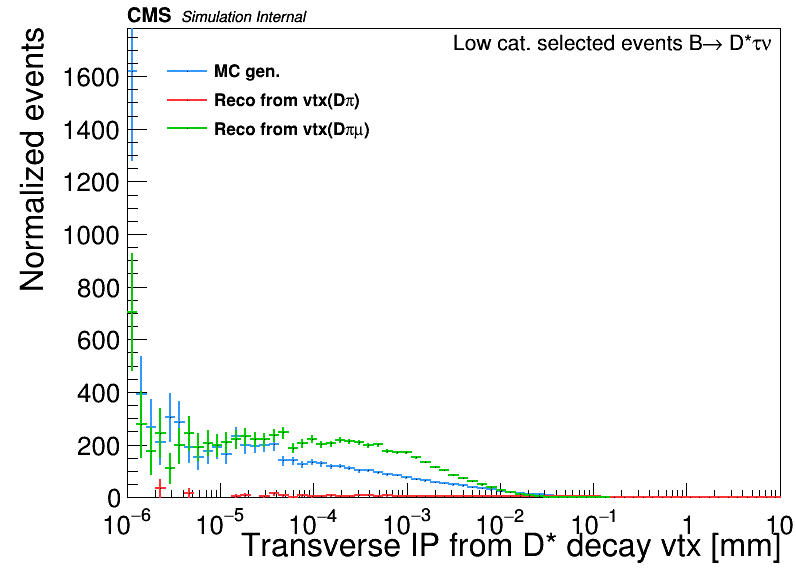

In [12]:
make_comp_plot_1D(
    [
        [dfTau['MC_mu_TransvIP_vtxDst'], 'MC gen.'],
        [dfTau['mu_dcaT_vtxDst'], 'Reco from vtx(D#pi)'],
        [dfTau['mu_dcaT_vtxDstMu'], 'Reco from vtx(D#pi#mu)']
    ],
    transformX = lambda x: 10*np.abs(x),
    binning=np.logspace(-6, 1, 70), setLog='x',
#     binning=[50, 0, 0.025],
    axis_title = ['Transverse IP from D* decay vtx [mm]', 'Normalized events'],
    leg_loc=[0.2, 0.75, 0.28, 0.15]
)

txt.SetTextAlign(33)
txt.DrawLatexNDC(0.97, 0.94, 'Low cat. selected events B#rightarrow D*#tau#nu')

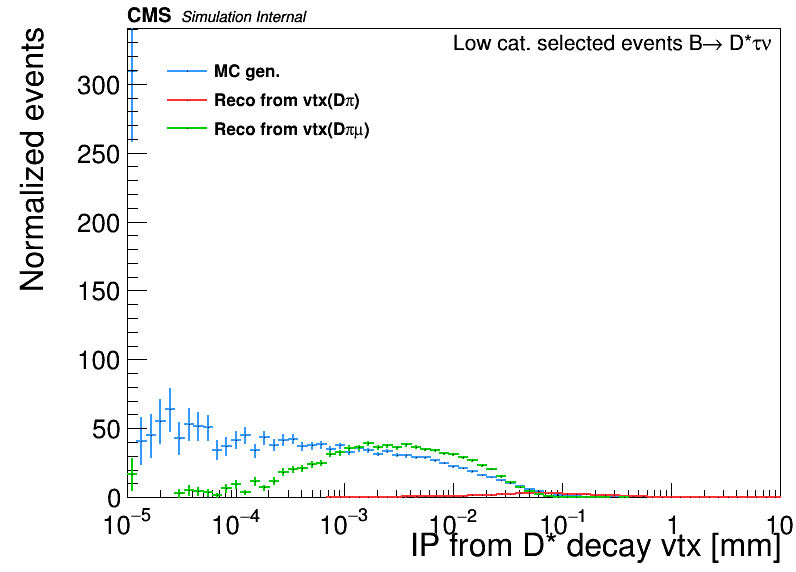

In [13]:
make_comp_plot_1D(
    [
        [dfTau['MC_mu_IP_vtxDst'], 'MC gen.'],
        [dfTau['mu_dca_vtxDst'], 'Reco from vtx(D#pi)'],
        [dfTau['mu_dca_vtxDstMu'], 'Reco from vtx(D#pi#mu)']
    ],
    transformX = lambda x: 10*np.abs(x),
    binning=np.logspace(-5, 1, 70), setLog='x',
#     binning=[50, 0, 0.025],
    axis_title = ['IP from D* decay vtx [mm]', 'Normalized events'],
    leg_loc=[0.2, 0.75, 0.28, 0.15]
)

txt.SetTextAlign(33)
txt.DrawLatexNDC(0.97, 0.94, 'Low cat. selected events B#rightarrow D*#tau#nu')

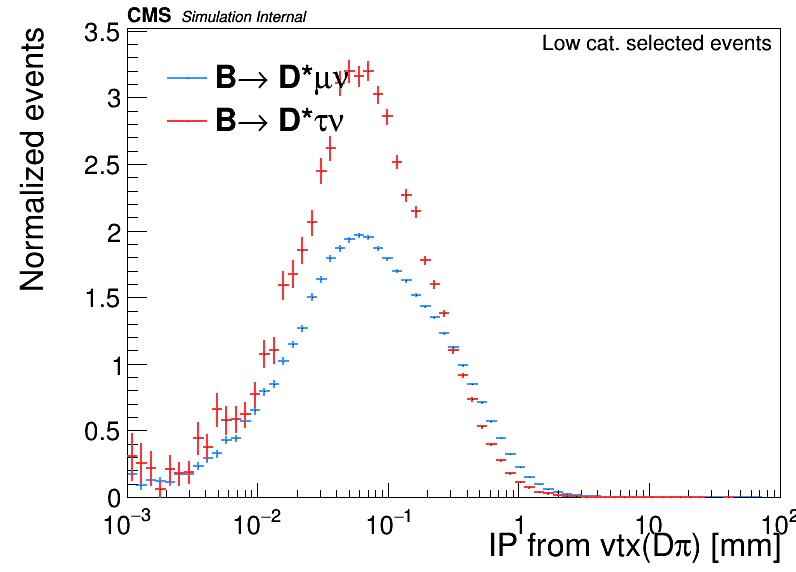

In [14]:
c = make_comp_plot_1D(
    [
        [dfMu['mu_dca_vtxDst'], label_dic['mu']],
        [dfTau['mu_dca_vtxDst'], label_dic['tau']],
    ],
    transformX = lambda x: 10*np.abs(x),
    binning=np.logspace(-3, 2, 70), setLog='x',
#     binning=[100, 0, 4], setLog='',
    axis_title = ['IP from vtx(D#pi) [mm]', 'Normalized events'],
    leg_loc=[0.2, 0.75, 0.28, 0.15]
)
txt.SetTextAlign(33)
txt.DrawLatexNDC(0.97, 0.94, 'Low cat. selected events')

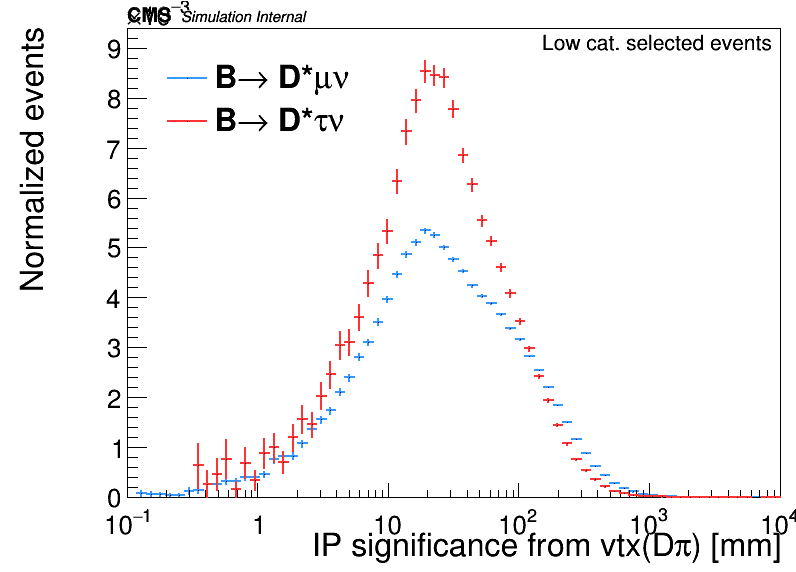

In [15]:
c = make_comp_plot_1D(
    [
        [dfMu['mu_sigdca_vtxDst'], label_dic['mu']],
        [dfTau['mu_sigdca_vtxDst'], label_dic['tau']],
    ],
    transformX = lambda x: 10*np.abs(x),
    binning=np.logspace(-1, 4, 70), setLog='x',
#     binning=[100, 0, 4], setLog='',
    axis_title = ['IP significance from vtx(D#pi) [mm]', 'Normalized events'],
    leg_loc=[0.2, 0.75, 0.28, 0.15]
)
txt.SetTextAlign(33)
txt.DrawLatexNDC(0.97, 0.94, 'Low cat. selected events')

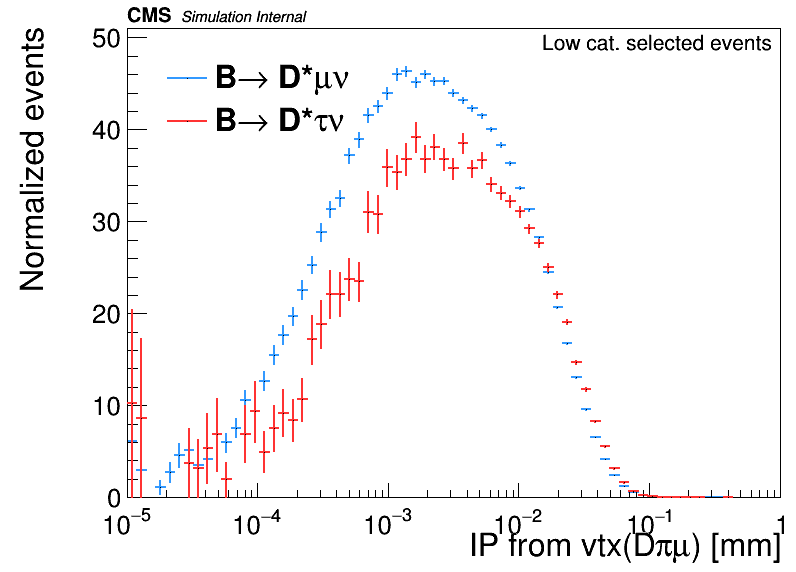

In [16]:
make_comp_plot_1D(
    [
        [dfMu['mu_dca_vtxDstMu'], label_dic['mu']],
        [dfTau['mu_dca_vtxDstMu'], label_dic['tau']],
    ],
    transformX = lambda x: 10*np.abs(x),
    binning=np.logspace(-5, 0, 70), setLog='x',
#     binning=[50, 0, 0.025],
    axis_title = ['IP from vtx(D#pi#mu) [mm]', 'Normalized events'],
    leg_loc=[0.2, 0.75, 0.28, 0.15]
)

txt.SetTextAlign(33)
txt.DrawLatexNDC(0.97, 0.94, 'Low cat. selected events')

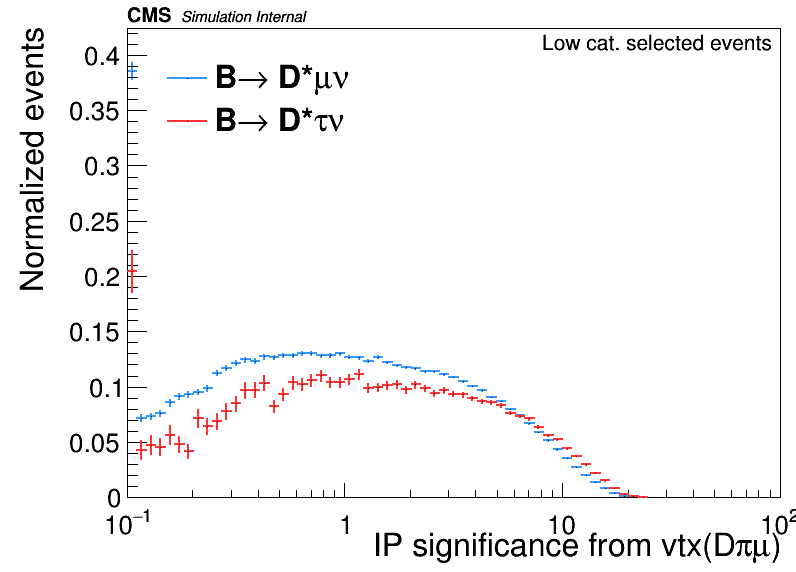

In [17]:
make_comp_plot_1D(
    [
        [dfMu['mu_sigdca_vtxDstMu'], label_dic['mu']],
        [dfTau['mu_sigdca_vtxDstMu'], label_dic['tau']],
#         [dfData['mu_sigdca_vtxDstMu'], label_dic['data'], 1],
    ],
    transformX = lambda x: 10*np.abs(x),
    binning=np.logspace(-1, 2, 70), setLog='x',
#     binning=[50, 0, 20],
    axis_title = ['IP significance from vtx(D#pi#mu)', 'Normalized events'],
    leg_loc=[0.2, 0.75, 0.28, 0.15]
)

txt.SetTextAlign(33)
txt.DrawLatexNDC(0.97, 0.94, 'Low cat. selected events')

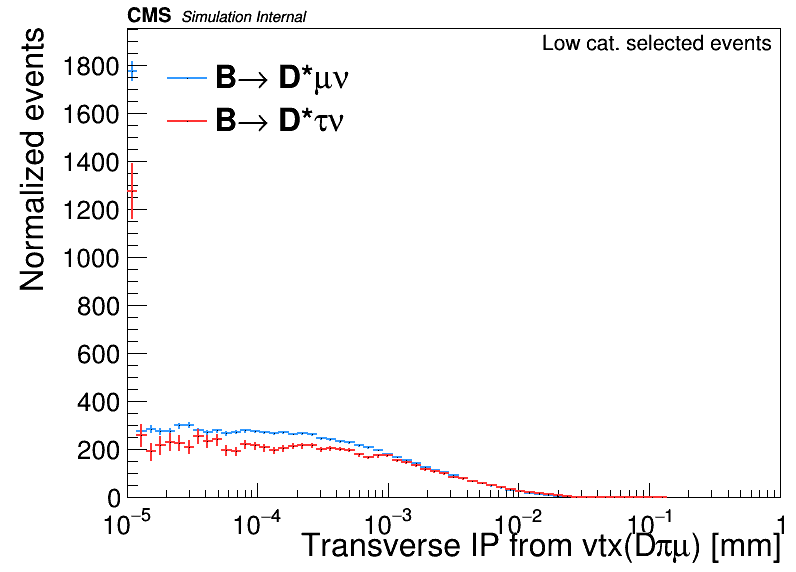

In [18]:
make_comp_plot_1D(
    [
        [dfMu['mu_dcaT_vtxDstMu'], label_dic['mu']],
        [dfTau['mu_dcaT_vtxDstMu'], label_dic['tau']],
    ],
    transformX = lambda x: 10*np.abs(x),
    binning=np.logspace(-5, 0, 70), setLog='x',
#     binning=[50, 0, 0.025],
    axis_title = ['Transverse IP from vtx(D#pi#mu) [mm]', 'Normalized events'],
    leg_loc=[0.2, 0.75, 0.28, 0.15]
)

txt.SetTextAlign(33)
txt.DrawLatexNDC(0.97, 0.94, 'Low cat. selected events')

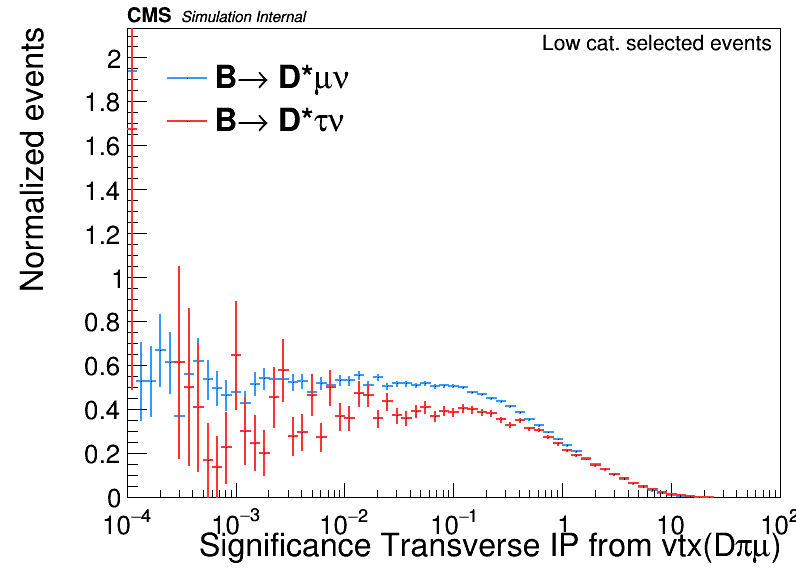

In [19]:
make_comp_plot_1D(
    [
        [dfMu['mu_sigdcaT_vtxDstMu'], label_dic['mu']],
        [dfTau['mu_sigdcaT_vtxDstMu'], label_dic['tau']],
    ],
    transformX = lambda x: 10*np.abs(x),
    binning=np.logspace(-4, 2, 70), setLog='x',
#     binning=[50, 0, 0.025],
    axis_title = ['Significance Transverse IP from vtx(D#pi#mu)', 'Normalized events'],
    leg_loc=[0.2, 0.75, 0.28, 0.15]
)

txt.SetTextAlign(33)
txt.DrawLatexNDC(0.97, 0.94, 'Low cat. selected events')